In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


**Importing library**

In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
print(os.listdir("../input/dogs-vs-cats/"))

Using TensorFlow backend.


['train.zip', 'test1.zip', 'sampleSubmission.csv']


**Image properties**

In [4]:
image_width,image_height=128,128
image_channel=3
image_size=(image_width, image_height)

**Data set**

In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r')
zip_ref.extractall('/tmp/train')
zip_ref.close()

In [6]:
filenames = os.listdir("/tmp/train/train")
categories=[]
for i in filenames:
    if i.split('.')[0]=='dog':
        categories.append(1)
    else:
        categories.append(0)
        

In [7]:
df=pd.DataFrame({'filenames':filenames,'category':categories})

In [8]:
df.head()

,filenames,category
0,dog.890.jpg,1
1,dog.1178.jpg,1
2,dog.7845.jpg,1
3,dog.4632.jpg,1
4,cat.3660.jpg,0


**EDA**

In [9]:
df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

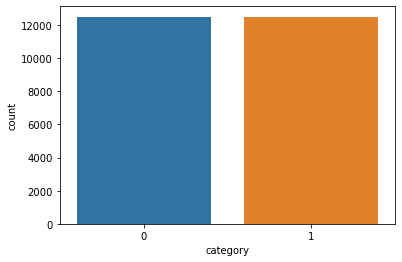

In [10]:
sns.countplot(df['category'])

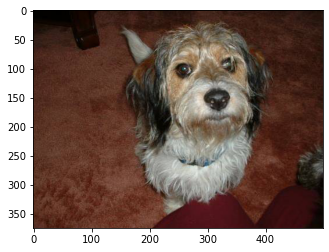

In [10]:
file_name=filenames[2]
image=load_img("/tmp/train/train/"+file_name)
plt.imshow(image)

**Building model**

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,Activation,BatchNormalization

In [12]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(image_width,image_height,image_channel)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),input_shape=(image_width,image_height,image_channel)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))



model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)       

Train generator

In [13]:
from sklearn.model_selection import train_test_split
df.category=df.category.replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,random_state=42)

In [14]:
train_df=train_df.reset_index(drop=True)
validate_df=validate_df.reset_index(drop=True)

In [15]:
train_df.head()

,filenames,category
0,dog.10381.jpg,dog
1,dog.1864.jpg,dog
2,cat.3131.jpg,cat
3,dog.12317.jpg,dog
4,dog.2524.jpg,dog


In [16]:
train_count=train_df.shape[0]
validation_count=validate_df.shape[0]

In [17]:
train_datagen=ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/tmp/train/train/", 
    x_col='filenames',
    y_col='category',
    target_size=image_size,
    class_mode='binary',
    batch_size=20
)


Found 20000 validated image filenames belonging to 2 classes.


In [18]:
test_generator=test_datagen.flow_from_dataframe(
    validate_df, 
    "/tmp/train/train/", 
    x_col='filenames',
    y_col='category',
    target_size=image_size,
    class_mode='binary',
    batch_size=20
)

Found 5000 validated image filenames belonging to 2 classes.


In [19]:
batch_size=20
trained_model = model.fit_generator(
    train_generator, 
    epochs=10,
    validation_data=test_generator,
    validation_steps=validation_count//batch_size,
    steps_per_epoch=train_count//batch_size,
    
)

Epoch 1/10
1000/1000 [==============================] - 466s 466ms/step - loss: 1.0361 - accuracy: 0.5753 - val_loss: 1.4616 - val_accuracy: 0.6040
Epoch 2/10
1000/1000 [==============================] - 461s 461ms/step - loss: 0.6439 - accuracy: 0.6560 - val_loss: 0.5382 - val_accuracy: 0.7014
Epoch 3/10
1000/1000 [==============================] - 457s 457ms/step - loss: 0.5990 - accuracy: 0.7003 - val_loss: 0.6828 - val_accuracy: 0.7428
Epoch 4/10
1000/1000 [==============================] - 454s 454ms/step - loss: 0.5769 - accuracy: 0.7126 - val_loss: 1.2601 - val_accuracy: 0.6126
Epoch 5/10
1000/1000 [==============================] - 455s 455ms/step - loss: 0.5771 - accuracy: 0.7075 - val_loss: 0.4457 - val_accuracy: 0.7582
Epoch 6/10
1000/1000 [==============================] - 454s 454ms/step - loss: 0.5651 - accuracy: 0.7196 - val_loss: 0.9986 - val_accuracy: 0.7492
Epoch 7/10
1000/1000 [==============================] - 453s 453ms/step - loss: 0.5658 - accuracy: 0.7207 - val_

**By using Xception**

Import vgg16

In [19]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [20]:
vgg=VGG16(input_shape=(image_width,image_height,image_channel),weights='imagenet',include_top=False)
for layers in vgg.layers:
    layers.trainable=False
x=Flatten()(vgg.output)
output_layer=Dense(1,activation='sigmoid')(x)
model_transfer=Model(input=vgg.input,output=output_layer)
model_transfer.summary()


58892288/58889256 [==============================] - 5s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [21]:
model_transfer.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [22]:
batch_size=20
trained_model = model_transfer.fit_generator(
    train_generator, 
    epochs=10,
    validation_data=test_generator,
    validation_steps=validation_count//batch_size,
    steps_per_epoch=train_count//batch_size,
    
)

Epoch 1/10
1000/1000 [==============================] - 251s 251ms/step - loss: 0.3354 - accuracy: 0.8508 - val_loss: 0.1990 - val_accuracy: 0.8454
Epoch 2/10
1000/1000 [==============================] - 247s 247ms/step - loss: 0.2850 - accuracy: 0.8761 - val_loss: 0.2575 - val_accuracy: 0.8960
Epoch 3/10
1000/1000 [==============================] - 253s 253ms/step - loss: 0.2733 - accuracy: 0.8850 - val_loss: 0.1495 - val_accuracy: 0.8988
Epoch 4/10
1000/1000 [==============================] - 249s 249ms/step - loss: 0.2596 - accuracy: 0.8896 - val_loss: 0.0789 - val_accuracy: 0.9030
Epoch 5/10
1000/1000 [==============================] - 250s 250ms/step - loss: 0.2549 - accuracy: 0.8928 - val_loss: 0.0775 - val_accuracy: 0.9012
Epoch 6/10
1000/1000 [==============================] - 254s 254ms/step - loss: 0.2546 - accuracy: 0.8940 - val_loss: 0.2373 - val_accuracy: 0.8870
Epoch 7/10
1000/1000 [==============================] - 254s 254ms/step - loss: 0.2505 - accuracy: 0.8967 - val_

In [23]:
model_transfer.save_weights("model_transfer.h5")

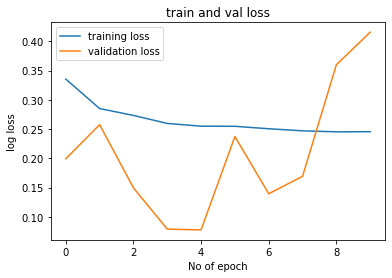

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(trained_model.history['loss'],label='training loss')
plt.plot(trained_model.history['val_loss'],label='validation loss')
plt.legend()
plt.ylabel('log loss')
plt.xlabel('No of epoch')
plt.title('train and val loss')
plt.show()
plt.savefig('train_val_loss')

**Predict**

In [25]:
import zipfile
zip_ref = zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip','r')
zip_ref.extractall('/tmp/test1')
zip_ref.close()

In [26]:
test_filenames = os.listdir("/tmp/test1/test1")
test_sample=pd.DataFrame({'filename':test_filenames})
test_sample=test_sample.reset_index(drop=True)
test_sample.head()


,filename
0,10435.jpg
1,6790.jpg
2,4644.jpg
3,1835.jpg
4,1102.jpg


In [27]:
test_sample.shape

(12500, 1)

In [28]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_sample, 
    "/tmp/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=image_size,
    shuffle=False
)

Found 12500 validated image filenames.


# predict Dog

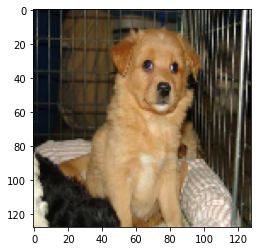

In [42]:
file_name=test_filenames[1]
image1=load_img("/tmp/test1/test1/"+file_name,target_size=image_size)
plt.imshow(image1)

In [43]:
from keras.preprocessing.image import image
from keras.applications.vgg16 import preprocess_input
x=image.img_to_array(image1)
x=np.expand_dims(x,axis=0)
data=preprocess_input(x)
model_transfer.predict(data)

array([[1.]], dtype=float32)

# predict cat

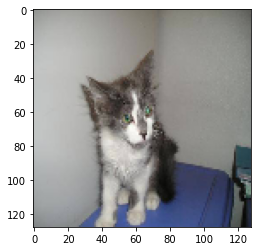

In [45]:
file_name=test_filenames[5]
image2=load_img("/tmp/test1/test1/"+file_name,target_size=image_size)
plt.imshow(image2)

In [46]:
from keras.preprocessing.image import image
from keras.applications.vgg16 import preprocess_input
x=image.img_to_array(image2)
x=np.expand_dims(x,axis=0)
data=preprocess_input(x)
model_transfer.predict(data)

array([[0.]], dtype=float32)

As observed in the prediction the model has correctly predicted cat as cat(0) and dog as dog(1)